In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [5]:
# dados da estação base
F = 23500.0 # Campo regional em nT
vB = 50.0   # amplitude da variacao diurna em nT

hora = np.linspace(0.0, 24.0, 1000, endpoint=True)
B = []
for h in hora:
  if h >= 6.0 and h <= 18.0:
    B.append(F + vB * np.sin((np.pi/12.0) * (h-6.0) ) + random.normalvariate(0.0, 1.0))
  else:
    B.append(F + random.normalvariate(0.0,1.0) )

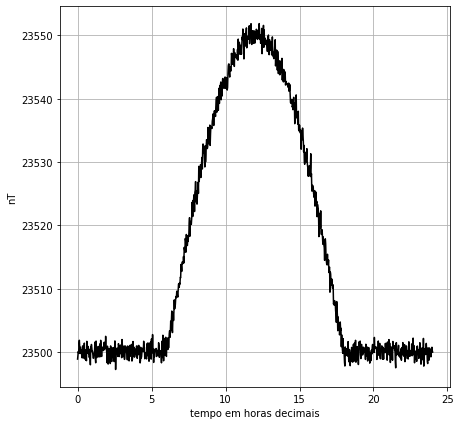

In [3]:
plt.figure(figsize=(7,7))
plt.plot(hora, B, 'k-')
plt.xlabel('tempo em horas decimais')
plt.grid()
plt.ylabel('nT')
plt.show()